# Artificial Neural Networks for Edge and Fog computing-based Energy Prediction 

In [32]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# load data
dataset = pd.read_csv('Main_Raw.csv', index_col=0)
# manually specify column names
#dataset.columns = []
dataset['DateTime'] = [datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in dataset["DateTime"]]
dataset.set_index('DateTime', inplace=True)
#dataset.index.name = 'date'
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
# save to file
dataset.to_csv('energy.csv')
dataset.head(5)

,TotalUsage,Month,TemperatureF,Humidity,Hour_y,Minute_y,Day_y,Weekend,Holiday
DateTime,,,,,,,,,
2016-01-01 00:00:00,19.843233,1,50.0,63.0,0,0,6,0,0
2016-01-01 01:00:00,18.462483,1,49.8,63.0,1,60,6,0,0
2016-01-01 02:00:00,17.414167,1,48.9,61.0,2,120,6,0,0
2016-01-01 03:00:00,15.914683,1,48.6,61.0,3,180,6,0,0
2016-01-01 04:00:00,19.195933,1,47.7,63.0,4,240,6,0,0


In [20]:
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline
# load dataset
dataset = pd.read_csv('energy.csv', header=0, index_col=0)
del dataset['Weekend']
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
print(dataset.shape)
dataset.head()

(17429, 8)


,TotalUsage,Month,TemperatureF,Humidity,Hour_y,Minute_y,Day_y,Holiday
DateTime,,,,,,,,
2016-01-01 00:00:00,19.843233,1,50.0,63.0,0,0,6,0
2016-01-01 01:00:00,18.462483,1,49.8,63.0,1,60,6,0
2016-01-01 02:00:00,17.414167,1,48.9,61.0,2,120,6,0
2016-01-01 03:00:00,15.914683,1,48.6,61.0,3,180,6,0
2016-01-01 04:00:00,19.195933,1,47.7,63.0,4,240,6,0


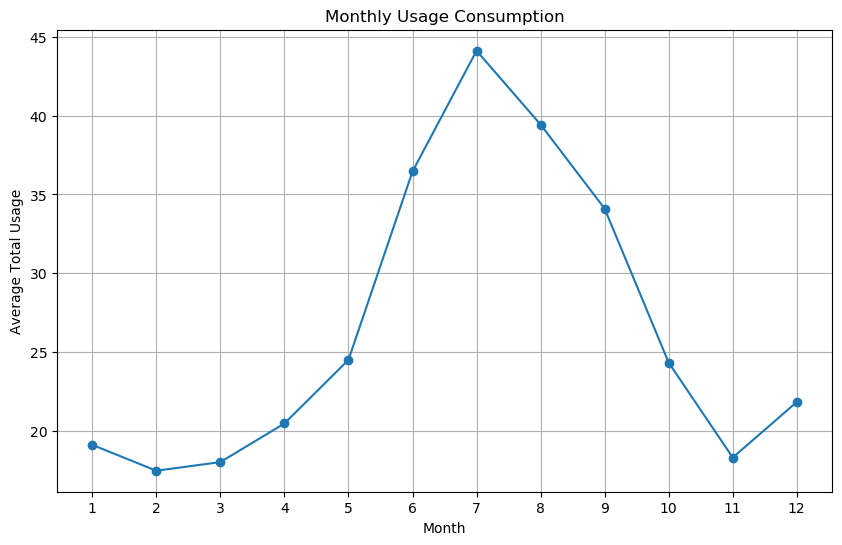

Month with the highest consumption: 7


In [33]:
# Group the data by 'Month' and calculate the average usage for each month
monthly_usage = dataset.groupby('Month')['TotalUsage'].mean().reset_index()

# Plot the data using a line chart
plt.figure(figsize=(10, 6))
plt.plot(monthly_usage['Month'], monthly_usage['TotalUsage'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Average Total Usage')
plt.title('Monthly Usage Consumption')
plt.xticks(range(1, 13))  # Set the x-axis ticks to represent the months (1 to 12)
plt.grid(True)  # Add grid lines to the plot for better readability
plt.show()

# Find the month with the highest consumption
max_consumption_month = monthly_usage.loc[monthly_usage['TotalUsage'].idxmax(), 'Month']
print("Month with the highest consumption:", max_consumption_month)


In [34]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [35]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [24]:
# load dataset
dataset = read_csv('energy.csv', header=0, index_col=0)
del dataset['Humidity']
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 1
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

(17428, 16)


In [36]:
# split into train and test sets
values = reframed.values
n_train_hours = 600 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(14400, 8) 14400 (14400,)
(14400, 1, 8) (14400,) (3028, 1, 8) (3028,)


Train on 14400 samples, validate on 3028 samples
Epoch 1/20
 - 1s - loss: 0.0883 - val_loss: 0.1748
Epoch 2/20
 - 1s - loss: 0.0815 - val_loss: 0.1480
Epoch 3/20
 - 1s - loss: 0.0587 - val_loss: 0.1003
Epoch 4/20
 - 1s - loss: 0.0456 - val_loss: 0.0535
Epoch 5/20
 - 1s - loss: 0.0415 - val_loss: 0.0408
Epoch 6/20
 - 1s - loss: 0.0401 - val_loss: 0.0380
Epoch 7/20
 - 1s - loss: 0.0390 - val_loss: 0.0366
Epoch 8/20
 - 1s - loss: 0.0379 - val_loss: 0.0356
Epoch 9/20
 - 1s - loss: 0.0371 - val_loss: 0.0349
Epoch 10/20
 - 1s - loss: 0.0364 - val_loss: 0.0344
Epoch 11/20
 - 1s - loss: 0.0360 - val_loss: 0.0344
Epoch 12/20
 - 1s - loss: 0.0358 - val_loss: 0.0345
Epoch 13/20
 - 1s - loss: 0.0357 - val_loss: 0.0350
Epoch 14/20
 - 1s - loss: 0.0358 - val_loss: 0.0353
Epoch 15/20
 - 1s - loss: 0.0358 - val_loss: 0.0358
Epoch 16/20
 - 1s - loss: 0.0358 - val_loss: 0.0362
Epoch 17/20
 - 1s - loss: 0.0358 - val_loss: 0.0361
Epoch 18/20
 - 1s - loss: 0.0358 - val_loss: 0.0361
Epoch 19/20
 - 1s - loss

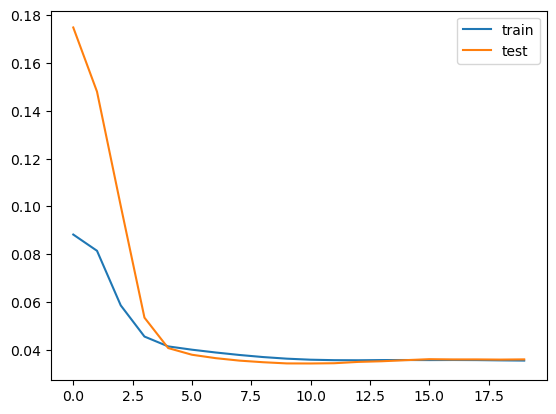

In [37]:
# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [38]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

In [39]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_z = inv_y
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3.636


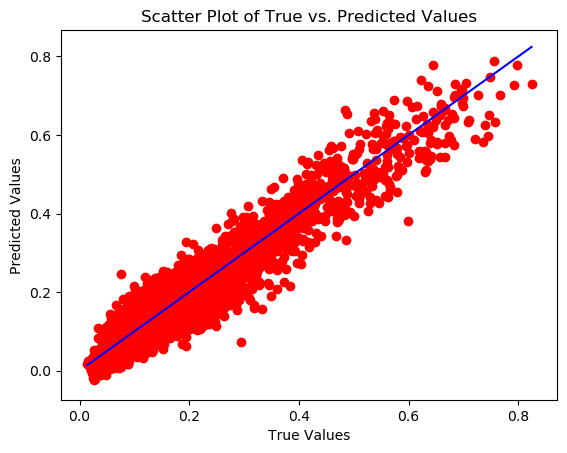

In [40]:
# Create a scatter plot of the true target values (Y_test) against the predicted target values (Y_pred)
plt.scatter(test_y,yhat , color='red')
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color='blue')  # Diagonal line for comparison
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of True vs. Predicted Values')
plt.show()

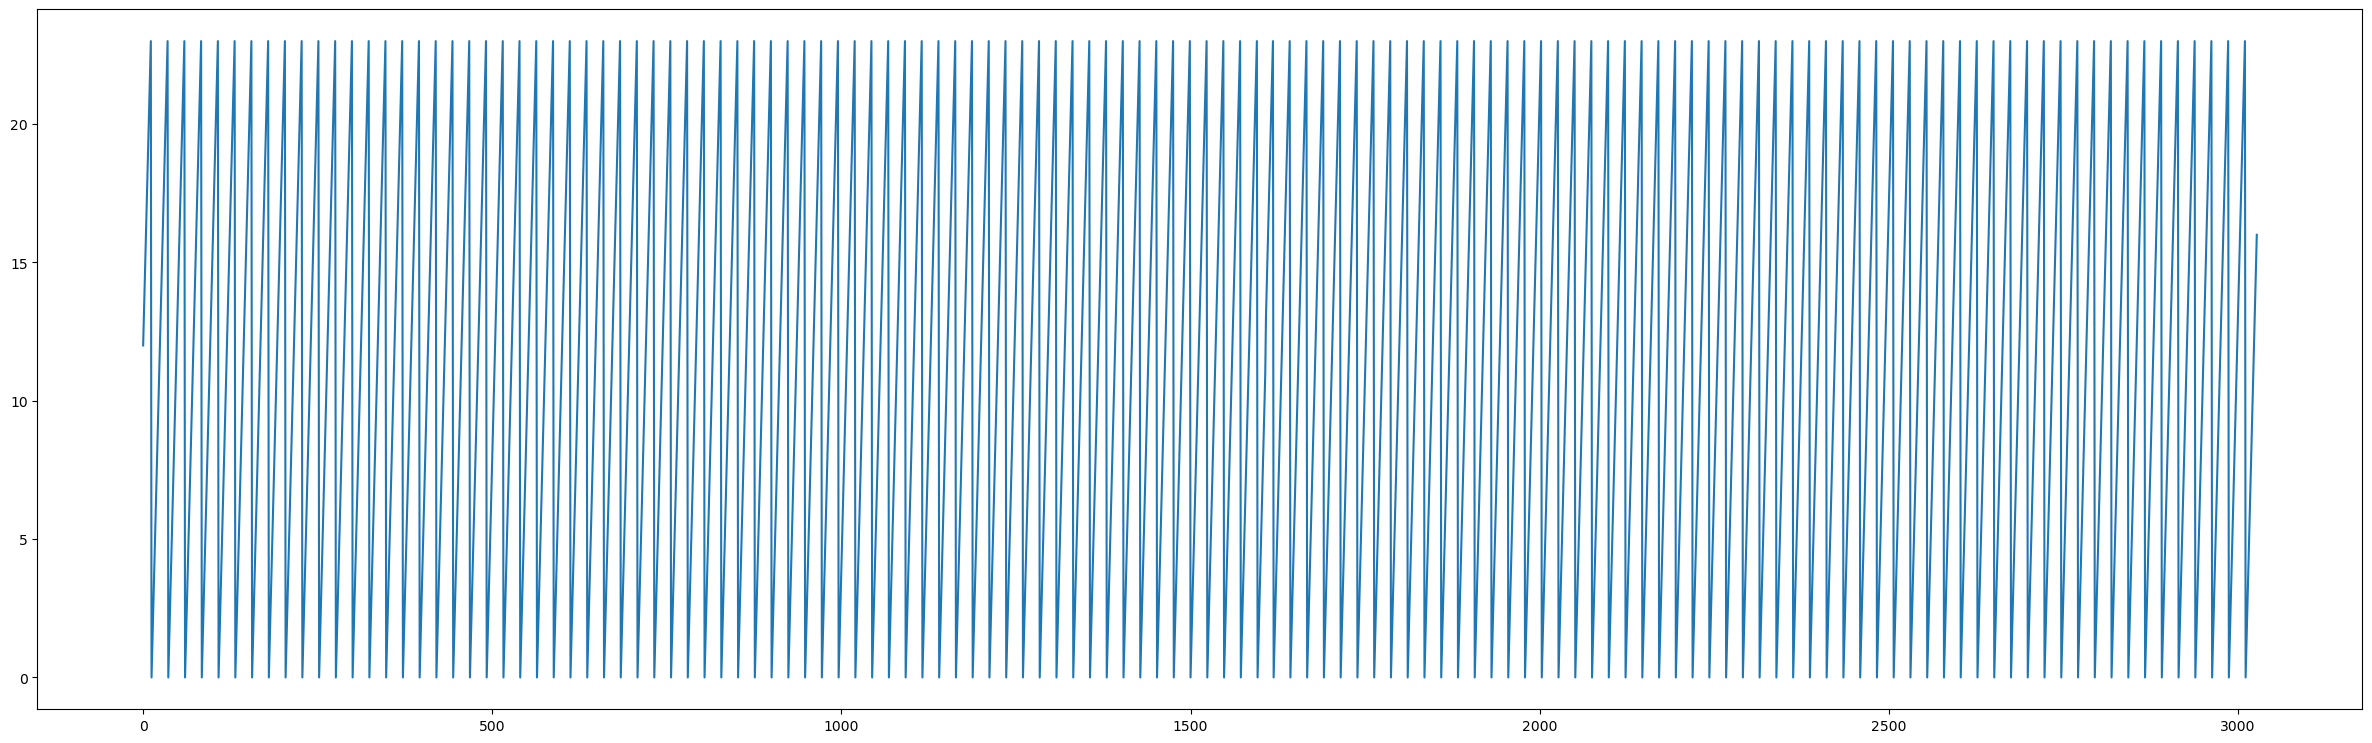

In [41]:
fig = pyplot.figure(figsize=(30,20))
ax2 = fig.add_subplot(211)
ax2.plot(inv_z[:,3])

[27.708183 25.607483 25.60072  ... 29.153448 30.28535  33.841385]


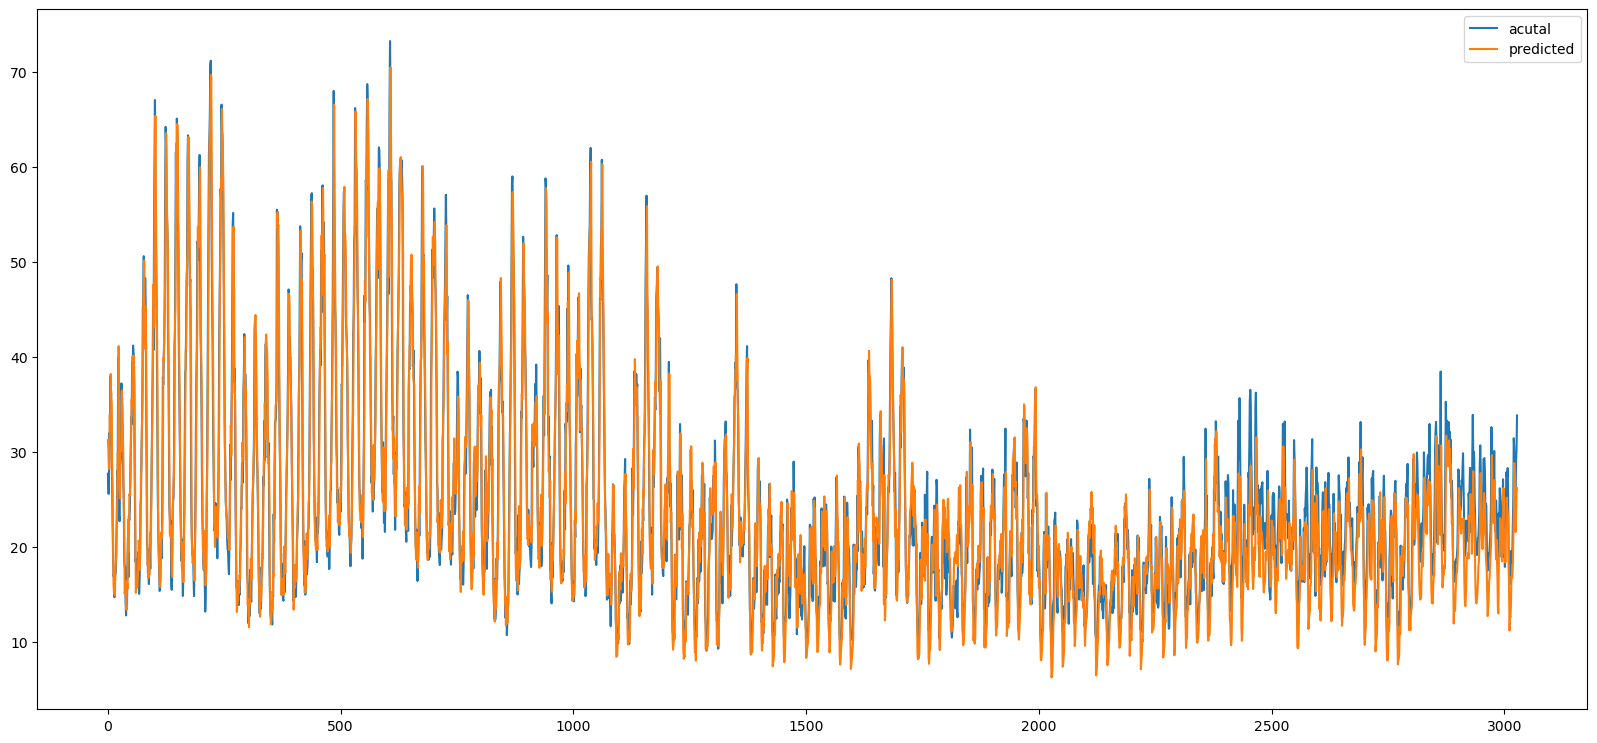

In [42]:
inv_y.shape
inv_yhat.shape
fig = pyplot.figure(figsize=(20,20))
ax1 = fig.add_subplot(211)
ax1.plot(inv_y,label='acutal')
ax1.plot(inv_yhat,label='predicted')
pyplot.legend()
print(inv_y)


In [43]:
test_y.shape

(3028, 1)

In [44]:
yhat.shape

(3028, 1)

In [45]:
df = pd.DataFrame(yhat)
df

,0
0,0.292727
1,0.279878
2,0.254338
3,0.255165
4,0.326426
...,...
3023,0.226341
3024,0.170355
3025,0.192554
3026,0.222624


In [46]:
df1 = pd.DataFrame(test_y)
df1

,0
0,0.248029
1,0.221444
2,0.221358
3,0.302116
4,0.287743
...,...
3023,0.192638
3024,0.224063
3025,0.266320
3026,0.280645


In [47]:
result_concat_cols = pd.concat([df, df1], axis=1)
result_concat_cols

,0,0
0,0.292727,0.248029
1,0.279878,0.221444
2,0.254338,0.221358
3,0.255165,0.302116
4,0.326426,0.287743
...,...,...
3023,0.226341,0.192638
3024,0.170355,0.224063
3025,0.192554,0.266320
3026,0.222624,0.280645
